In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Aplicaciones Avanzadas/DataBank"
!ls

/content/drive/MyDrive/Aplicaciones Avanzadas/DataBank
Fake.csv		    fake_news_model.keras    scaler.pkl
fake_news_classifier.h5     label_encoder.pkl	     tfidf_vectorizer.pkl
fake_news_classifier.keras  noticia_prueba_fake.txt  True.csv
fake_news_dataset.csv	    noticia_prueba_real.txt


In [3]:
# Importación de librerías
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import joblib
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Descargar el modelo a mi computadora
from google.colab import files

%matplotlib inline

# Obtener el set de datos



Se obtuvo el dataset de noticias falsas de la plataforma Kaggle y se almacenó en Google Drive

In [4]:
# Lectura de los archivos
df_fake = pd.read_csv("Fake.csv")
df_fake['label'] = 'fake'
df_true = pd.read_csv('True.csv')
df_true['label'] = 'real'

In [5]:
# Concatenar ambos datasets
df = pd.concat((df_fake,df_true),axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


In [6]:
# Vista inicial del dataset
print(df.head())
print(df.info())
print(df.isnull().sum())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date label  
0  December 31, 2017  fake  
1  December 31, 2017  fake  
2  December 30, 2017  fake  
3  December 29, 2017  fake  
4  December 25, 2017  fake  
<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 

In [7]:
# Dimension del dataset (filas, columnas)
df.shape

(44898, 5)

In [8]:
print(df['label'].value_counts())

label
fake    23481
real    21417
Name: count, dtype: int64


# Separación del set de pruebas y del set de entrenamiento

Eliminar palabras vacías que no aportan significado relevante con *Stopwords*

In [9]:
# Descargar stopwords (solo la primera vez)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# Función para la limpieza del texto
def limpiar_texto(texto):
    texto = texto.lower()  # Convertir a Minúsculas
    texto = re.sub(r'\d+', '', texto)  # Quitar números
    texto = re.sub(r'[^\w\s]', '', texto)  # Quitar signos de puntuación
    texto = texto.strip()  # Eliminar espacios al inicio/final
    texto = re.sub(r'\s+', ' ', texto)  # Espacios múltiples → uno solo

    # Eliminar stopwords
    palabras = texto.split()
    palabras = [p for p in palabras if p not in stop_words]
    return ' '.join(palabras)

***Label Encoding***

Para distinguir el target a binario,  se utilizará el Label encoder, ya que:

*   Solo hay dos categorias (fake, real)
*   Normaliza etiquetas en valores numéricos
*   Se utiliza menos memoria


In [11]:
# Rellenar valores nulos
df = df.fillna('')

# Combinación del título y texto de la noticia
df['content'] = df['title'] + ' ' + df['text']

# Codificar etiquetas con Label Encoding
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Features seleccionadas (title y content) y etiquetas (label)
X = df['content']
y = df['label']

# Limpiar el contenido
df['content'] = df['content'].apply(limpiar_texto)

In [12]:
df.head()

,title,text,subject,date,label,content
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,donald trump sends embarrassing new years eve ...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,sheriff david clarke becomes internet joke thr...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,trump obsessed even obamas name coded website ...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,pope francis called donald trump christmas spe...


Dividimos el dataset para tener el conjunto que será para entrenamiento y el conjunto que será para pruebas (train y test)

In [13]:
# 80% train y 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesado de datos

In [14]:
# Lemming (Palabras Vacías)
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatizar_texto(texto):
  palabras = texto.split()
  palabras = [lemmatizer.lemmatize(p) for p in palabras]
  return ' '.join(palabras)

# Aplicar lemmatization a la columna 'content'
X_train = X_train.apply(lemmatizar_texto)
X_test = X_test.apply(lemmatizar_texto)

[nltk_data] Downloading package wordnet to /root/nltk_data...


### Vectorización del texto (TF-IDF)

In [15]:
# Vectorización de los sets de prueba y de entrenamiento
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, min_df=5, max_features=5000) # Ignora términos que aparecen en más del 70% de los documentos.

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

X_train_arr = X_train_tfidf.toarray()
X_test_arr = X_test_tfidf.toarray()

El **StandardScaler** se utiliza para estandarizar los datos, es decir, para escalar las características de los datos de entrada de modo que tengan una media de 0 y una desviación estándar de 1.

Como es una **matriz dispersa** en la que la mayoría de los valores son ceros (como las que suelen generarse al usar representaciones como TF-IDF en procesamiento de texto), se desactiva la opción (with_mean=False). Solo se toma en cuenta la desviación estandar. Se debe tener cuidado al escalar los datos para no romper su estructura dispersa.

In [16]:
scaler = StandardScaler(with_mean=False)  # with_mean=False porque es sparse matrix
X_train_scaled = scaler.fit_transform(X_train_arr)
X_test_scaled = scaler.transform(X_test_arr)

*   **Sequential**: Modelo de red neuronal donde las capas se apilan secuencialmente (una tras otra). Cada capa tiene exactamente un tensor de entrada y uno de salida, ideal para arquitecturas simples
*   **Dense**: Capa de neuronas totalmente conectada. Cada neurona recibe todas las salidas de la capa anterior.
*   **Dropout**:
Técnica de regularización que desactiva aleatoriamente un porcentaje de neuronas durante el entrenamiento para evitar el sobreajuste (overfitting).

# Implementación de Modelo

Dropout nos ayuda a evitar que el modelo se aprenda de memoria los datos de la clase mayoritaria

In [17]:
# Determinar la dimensión de entrada del vectorizador TF-IDF
input_dim = X_train_scaled.shape[1] # (rows, columns)

# Sequential: Modelo de red neuronal donde las capas se apilan secuencialmente (una tras otra).

model = Sequential([
    Dense(64, activation='relu', input_dim=input_dim),
    Dropout(0.5),  # Aumentar el Dropout ayuda
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Imprime el resumen del modelo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,177 (1.23 MB)

 Trainable params: 322,177 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_test_scaled, y_test), batch_size=64)

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8473 - loss: 0.3469 - val_accuracy: 0.9835 - val_loss: 0.0481
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9827 - loss: 0.0533 - val_accuracy: 0.9875 - val_loss: 0.0383
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9904 - loss: 0.0306 - val_accuracy: 0.9896 - val_loss: 0.0341
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9940 - loss: 0.0214 - val_accuracy: 0.9908 - val_loss: 0.0336
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9953 - loss: 0.0152 - val_accuracy: 0.9913 - val_loss: 0.0346
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9964 - loss: 0.0126 - val_accuracy: 0.9915 - val_loss: 0.0371
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9966 - loss: 0.0106 - val_accuracy: 0.9910 - val_loss: 0.0398
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9970 - loss: 0.0094 - val_accuracy: 

In [19]:
# Correr esta celda para cargar la historia del modelo en un pandas DataFrame
frame = pd.DataFrame(history.history)

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

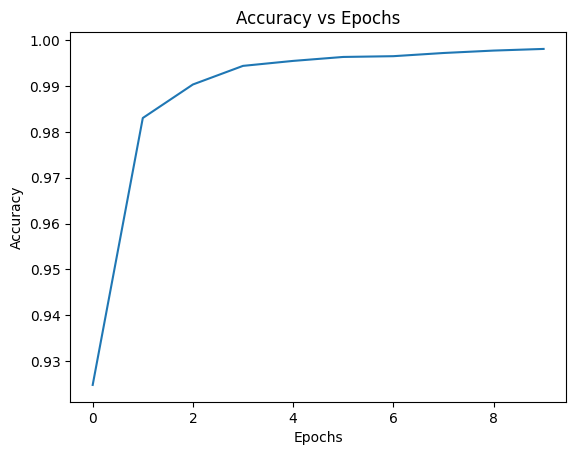

In [20]:
# Correr esta celda para graficar Accuracy vs Epochs
acc_plot = frame.plot(y="accuracy", title="Accuracy vs Epochs", legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss')]

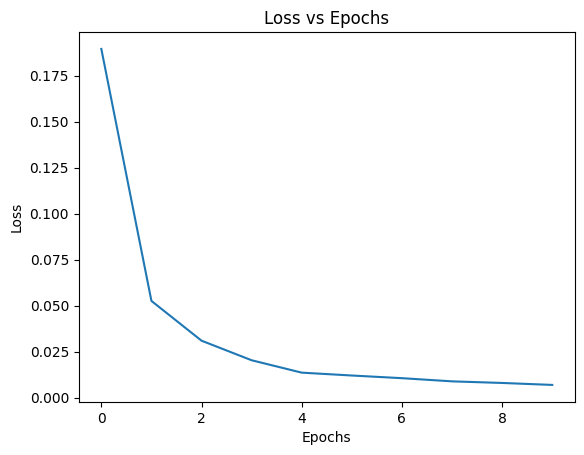

In [21]:
# Correr esta celda para graficar Loss vs Epochs
acc_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Loss")

# Evaluación inicial del modelo

Threshold a 0.3 para no ser tan duros con los casos de "yes" si no, darle mas oportunidad al modelo de darnos resultados cuando no esta convencido.


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9904 - loss: 0.0394
Accuracy: 0.9917594790458679

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4733
           1       0.99      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



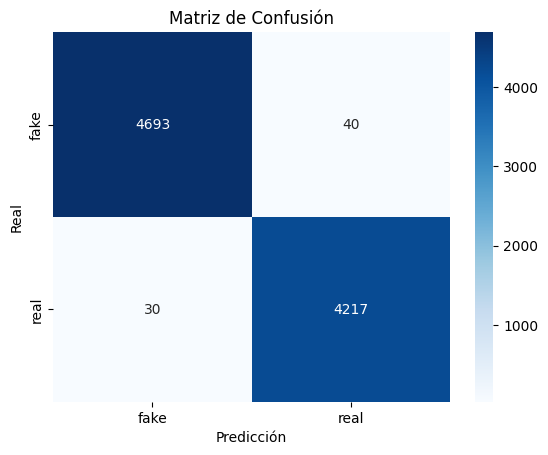

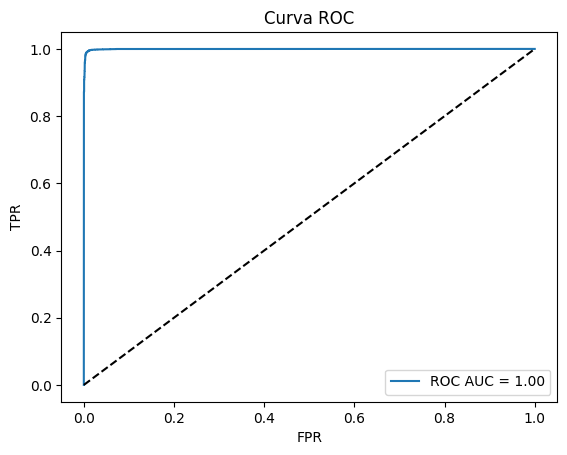

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import numpy as np

# Predicciones
y_pred_prob = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_prob >= 0.3).astype(int)

# Reporte

# Returns the loss value & metrics values for the model in test mode.
print("Accuracy:", model.evaluate(X_test_scaled, y_test)[1])

# Contruir un reporte de texto mostrando las metricas de clasificacion principales
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Get the inverse transformed labels
y_test_original = le.inverse_transform(y_test)
y_pred_original = le.inverse_transform(y_pred)

# Confusion matrix with original labels
cm = confusion_matrix(y_test_original, y_pred_original)

# Get the class labels from the LabelEncoder
class_labels = le.classes_

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='ROC AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


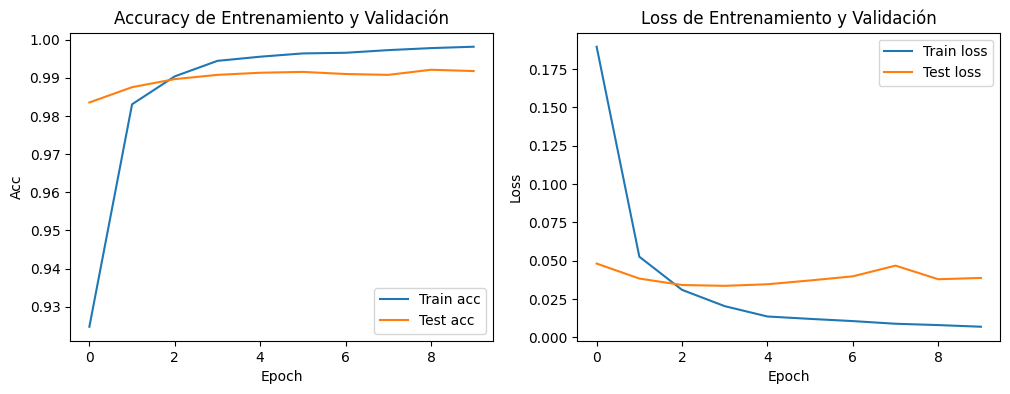

In [23]:
# Graficar precisión y pérdida a lo largo de las épocas
plt.figure(figsize=(12, 4))

# Graficar precisión de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Test acc')
plt.title('Accuracy de Entrenamiento y Validación')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()

# Graficar pérdida de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.title('Loss de Entrenamiento y Validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

De la prediccion:
* Precision: Cuantos eran realmente positivos
* Recall: De los TP, cuantos detecto el modelo
* F1 Score: Media entre Precision y Recall (para datos desbalanceados)
* Support: Cuantos yes y no había


## Guardar el modelo

In [24]:
# Guardar el modelo
model.save('fake_news_classifier.keras')

#files.download('fake_news_classifier.keras')